In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import gzip
import copy
import pickle as pk
import heapq as hp

import networkx as nx
from networkx.algorithms import bipartite, components, shortest_paths

# Importing the datasets, cleaning, transforming

## Import

**Instacart datasets** (provided) : https://www.instacart.com/datasets/grocery-shopping-2017 . The instacart datasets consist in a group of 5 different datasets, each adopting a different point of view 
* "products", a dataset based on the product point of view, describing to which aisle and department it belongs to
* "aisles", a dataset that enriches "products" by describing each aisle formally
* "departments", a dataset that enriches "products" by describing each department formally
* "orders", a dataset based on the order point of view, describing when it was purchased
* "order_products_prior", a dataset based on both the order and product point of view, associating each order with the products that were purchased

After loading the datasets, we verify whether there are any missing values. 

In [2]:
products = pd.read_csv('data/products.csv', sep=',')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [3]:
aisles = pd.read_csv('data/aisles.csv', sep=',')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
departments = pd.read_csv('data/departments.csv', sep=',')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
orders = pd.read_csv('data/orders.csv', sep=',')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
history = pd.read_csv('data/order_products__prior.csv', sep=',')
history.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


## Gathering all datasets

**Create a dataset with all useful information gathered : products_litteral**

We first add the names of the aisle and department in the _products_ dataset, instead of the ID, by merging the datasets :

In [7]:
products_litteral = pd.merge(pd.merge(products, aisles, on='aisle_id'), departments, on='department_id').drop(['aisle_id', 'department_id'], axis=1)
products_litteral.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


Save and/or load the dataframe

In [8]:
products_litteral.to_pickle('products_litteral.pk')

In [9]:
products_litteral = pd.read_pickle('products_litteral.pk')

# Make graphs

Make a dataframe containing the orders with the details of the products

In [10]:
orders_products = pd.merge(orders, history, on='order_id').drop(['add_to_cart_order', 'reordered'], axis=1)

In [11]:
orders_products.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id
0,2539329,1,prior,1,2,8,NaN,196
1,2539329,1,prior,1,2,8,NaN,14084
2,2539329,1,prior,1,2,8,NaN,12427
3,2539329,1,prior,1,2,8,NaN,26088
4,2539329,1,prior,1,2,8,NaN,26405


Save and/or load the dataframe

In [ ]:
orders_products.to_pickle('orders_products.pk')

In [3]:
orders_products = pd.read_pickle('orders_products.pk')

In [4]:
orders_products.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id
0,473747,1,prior,3,3,12,21.0,196
1,473747,1,prior,3,3,12,21.0,12427
2,473747,1,prior,3,3,12,21.0,10258
3,473747,1,prior,3,3,12,21.0,25133
4,473747,1,prior,3,3,12,21.0,30450


Now, we need to select only food-related products.

Because dataframes containing all the products and orders are really big to handle, we separate products by aisle and store each aisle's dataframe separately.

In [18]:
food_depts = ['bulk', 'meat seafood', 'snacks', 'beverages', 'frozen', 'dairy eggs', 'canned goods', 'dry goods pasta', 'produce', 'bakery', 'deli', 'breakfast', 'alcohol', 'pantry', 'international']

In [19]:
food_aisles = {row.aisle for i, row in products_litteral.iterrows() if row.department in food_depts}

Save and/or load the dataframe

In [21]:
with open('food_aisles.pk', 'wb') as file:
    pk.dump(food_aisles, file)

In [6]:
with open('food_aisles.pk', 'rb') as file:
    food_aisles = pk.load(file)

For each aisle, make the dataframe containing all its products' information (and save/load)

In [7]:
by_aisle = {}
for aisle in food_aisles:
    by_aisle[aisle] = products_litteral[products_litteral.aisle==aisle]
    by_aisle[aisle].to_pickle('by_aisle_'+aisle+'.pk')

In [50]:
by_aisle = {}
for aisle in food_aisles:
    by_aisle[aisle] = pd.read_pickle('by_aisle_'+aisle+'.pk')

In [8]:
# this is needed otherwise the kernel will end up dying because it is overloaded
del(products_litteral)

For each aisle, make the dataframe containing all orders (and save/load).

In [32]:
orders_products_by_aisle = {}
for aisle in food_aisles:
    orders_products_by_aisle[aisle] = pd.merge(orders_products, by_aisle[aisle], on='product_id')[['user_id', 'product_id', 'order_id', 'product_name']]


Now count the number of orders of each product for each user (and save/load).

In [ ]:
orders_users_by_aisle = {}
for aisle in food_aisles:
    orders_users_by_aisle[aisle] = orders_products_by_aisle[aisle].groupby(['user_id', 'product_id', 'product_name']).count().rename(columns={'order_id':'nb_orders'})
    orders_users_by_aisle[aisle].to_pickle('orders_users_by_aisle_'+aisle+'.pk')
    print(orders_users_by_aisle[aisle].head())

In [22]:
orders_users_by_aisle = {}
for aisle in food_aisles:
    orders_users_by_aisle[aisle] = pd.read_pickle('orders_users_by_aisle_'+aisle+'.pk')
    print(orders_users_by_aisle[aisle].head())

                                                                     nb_orders
user_id product_id product_name                                               
14      15134      Strawberry Gelatin                                        1
95      13368      Organic Cooked Vanilla Pudding & Pie Filling Mix          1
117     17627      Butterscotch Pudding                                      1
152     4357       Organic Chocolate Almondmilk Pudding                      1
154     40443      Tapioca Pudding Snacks                                    1
                                            nb_orders
user_id product_id product_name                      
2       8138       Traditional Hummus               1
        32139      Hommus Classic Original          3
        33276      Kalamata Olive Spread            2
        49451      Artichoke Spinach Dip            1
10      30489      Original Hummus                  3
                                                   nb_orders
user_id 

We want to normalize the number of orders (_i.e._ divide by the total number of food buys for each user) because we are omre interested in the preference of users for some products (relatively to other products) than actual number of orders.

To do this, we first sum the number of buys of each user of each aisle, and then sum over aisles for each user.

In [23]:
tot_user_by_aisle = {}
for aisle in food_aisles:
    orders_users_by_aisle[aisle] = orders_users_by_aisle[aisle].reset_index()
    tot_user_by_aisle[aisle] = orders_users_by_aisle[aisle][['user_id', 'nb_orders']].groupby('user_id').sum().rename(columns={'nb_orders':'tot_orders'})
    print(tot_user_by_aisle[aisle].head())

         tot_orders
user_id            
14                1
95                1
117               1
152               1
154               1
         tot_orders
user_id            
2                 7
10                4
12                1
18                1
19                1
         tot_orders
user_id            
4                 1
87                1
116               1
310               2
314               1
         tot_orders
user_id            
2                 2
10                4
17                3
19                3
32                1
         tot_orders
user_id            
12                1
13                4
19                1
21                2
26                1
         tot_orders
user_id            
14                1
42                3
56                2
107               1
114               1
         tot_orders
user_id            
14                2
16                1
19                4
31                3
32                2
         tot_orders


This dataframe contains the total number of buys for each user in all food aisles:

In [42]:
tot_user = pd.concat(tot_user_by_aisle[aisle] for aisle in food_aisles).groupby('user_id').sum()
tot_user.head()

,tot_orders
user_id,
1,18
2,96
3,35
4,9
5,12


Save and/or load the dataframe

In [43]:
tot_user.to_pickle('tot_user.pk')

In [24]:
tot_user = pd.read_pickle('tot_user.pk')

Use this total number of buys to normalise counts for each aisle:

In [41]:
tot_user.replace(0, np.nan)
tot_user.columns = ['nb_orders']
orders_users_norm_by_aisle = {}
for aisle in food_aisles:
    orders_users_by_aisle[aisle] = orders_users_by_aisle[aisle].set_index(['user_id', 'product_id'])
    orders_users_norm_by_aisle[aisle] = orders_users_by_aisle[aisle][['nb_orders']] / tot_user
    orders_users_norm_by_aisle[aisle].to_pickle('orders_users_norm_by_aisle_'+aisle+'.pk')

In [5]:
orders_users_norm_by_aisle = {}
for aisle in food_aisles:
    orders_users_norm_by_aisle[aisle] = pd.read_pickle('orders_users_norm_by_aisle_'+aisle+'.pk')

NameError: name 'food_aisles' is not defined

In [ ]:
del(orders_products_by_aisle)

Now is time to build the graphs.

First, we create (for each aisle) a bipartite graph where all products are connected to all users who have ordered them at least once. The weight of the edge between one user and a product they have bought is the normalized number of times they have bought this product.

In [6]:
graphs = {aisle: nx.Graph() for aisle in food_aisles}

# first, create the nodes:
for aisle in food_aisles:
    # products nodes
    for prod in by_aisle[aisle]['product_id'].unique():
        graphs[aisle].add_node(prod, bipartite=0)
    # user nodes (use negative id to distinguish them from product ids)
    for user in orders_users_norm_by_aisle[aisle].reset_index().user_id.unique():
        graphs[aisle].add_node(-user, bipartite=1)


In [7]:
# second, add edges between the nodes
for aisle in food_aisles:
    for (user, prod), row in orders_users_norm_by_aisle[aisle].iterrows():
        graphs[aisle].add_edge(prod, -user, weight=row['nb_orders'])
    nx.write_gpickle(graphs[aisle], "users_and_prods_graph_"+aisle+'.gpk')
    print('Done', aisle)

Done packaged produce
Done tofu meat alternatives
Done fresh pasta
Done doughs gelatins bake mixes
Done nuts seeds dried fruit
Done meat counter
Done bread
Done frozen breakfast
Done milk
Done seafood counter
Done energy granola bars
Done coffee
Done packaged meat
Done bulk dried fruits vegetables
Done dry pasta
Done tea
Done instant foods
Done preserved dips spreads
Done frozen meals
Done other creams cheeses
Done bulk grains rice dried goods
Done marinades meat preparation
Done hot cereal pancake mixes
Done canned meat seafood
Done salad dressing toppings
Done specialty wines champagnes
Done fresh herbs
Done trail mix snack mix
Done granola
Done fruit vegetable snacks
Done spreads
Done breakfast bars pastries
Done prepared soups salads
Done butter
Done oils vinegars
Done buns rolls
Done crackers
Done fresh fruits
Done chips pretzels
Done cookies cakes
Done specialty cheeses
Done poultry counter
Done bakery desserts
Done grains rice dried goods
Done soy lactosefree
Done hot dogs bacon

In [ ]:
graphs = {}
for aisle in food_aisles:
    graphs[aisle] = nx.read_gpickle("users_and_prods_graph_"+aisle+'.gpk')
    print('Loaded', aisle)

dept = 'produce'
graphs[dept] = nx.Graph()
for prod in by_dept[dept]['product_id'].unique():
    graphs[dept].add_node(prod, bipartite=0)
for user in orders.user_id.unique():
    graphs[dept].add_node(-user, bipartite=1)
for (user, prod, name), row in orders_users_by_dept[dept].iterrows():
    graphs[dept].add_edge(prod, -user, weight=row['nb_orders'])

In [9]:
del(graphs)

Now we project the bipartite graph on the _products only_.

The weight between two products is the average (normalized) number of orders of the two products over all common users, multiplied by the square of the number of users in common.

In [10]:
# define the weight of inter-product edges
def my_weight(G, u, v):
    w = 0
    n = 0
    for nbr in set(G[u]) & set(G[v]):
        n += 1
        w += (G[u][nbr].get('weight', 1) + G[v][nbr].get('weight', 1)) / 2
    return w * n   # divide by n for average and multiply by n**2

In [57]:
# project on products using this weight function
prod_graphs = {}
for aisle in food_aisles:
    #print('\n', dept)
    G = nx.read_gpickle("users_and_prods_graph_"+aisle+'.gpk')
    prod_graphs[aisle] = bipartite.generic_weighted_projected_graph(G, {n for n, d in G.nodes(data=True) if d['bipartite']==0}, weight_function=my_weight)
    nx.write_gpickle(prod_graphs[aisle], 'prod_graphs_'+aisle+'.gpk')
    print('Done', aisle)

Done packaged produce
Done tofu meat alternatives
Done fresh pasta
Done doughs gelatins bake mixes
Done nuts seeds dried fruit
Done meat counter
Done bread
Done frozen breakfast
Done milk
Done seafood counter
Done energy granola bars
Done coffee
Done packaged meat
Done bulk dried fruits vegetables
Done dry pasta
Done tea
Done instant foods
Done preserved dips spreads
Done frozen meals
Done other creams cheeses
Done bulk grains rice dried goods
Done marinades meat preparation
Done hot cereal pancake mixes
Done canned meat seafood
Done salad dressing toppings
Done specialty wines champagnes
Done fresh herbs
Done trail mix snack mix
Done granola
Done fruit vegetable snacks
Done spreads
Done breakfast bars pastries
Done prepared soups salads
Done butter
Done oils vinegars
Done buns rolls
Done crackers
Done fresh fruits
Done chips pretzels
Done cookies cakes
Done specialty cheeses
Done poultry counter
Done bakery desserts
Done grains rice dried goods
Done soy lactosefree
Done hot dogs bacon

In [12]:
del(prod_graphs)


 frozen meat seafood
Name: 
Type: Graph
Number of nodes: 229
Number of edges: 1644
Average degree:  14.3581

 bakery desserts
Name: 
Type: Graph
Number of nodes: 297
Number of edges: 1122
Average degree:   7.5556

 soft drinks
Name: 
Type: Graph
Number of nodes: 463
Number of edges: 11788
Average degree:  50.9201


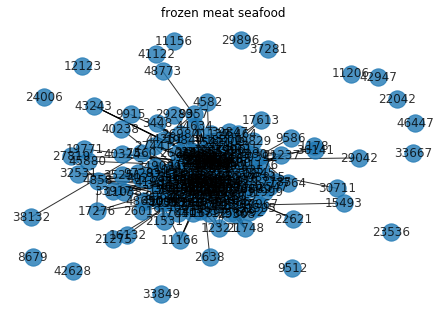

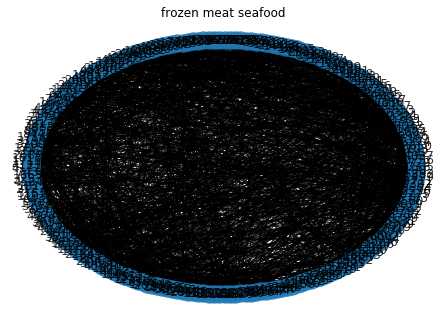

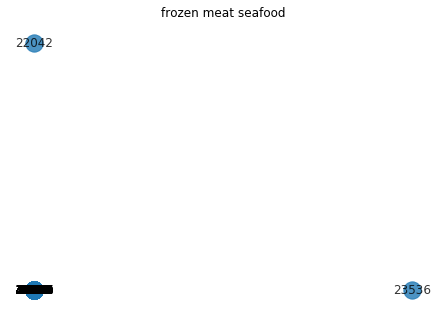

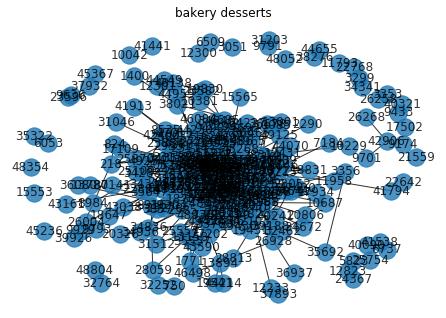

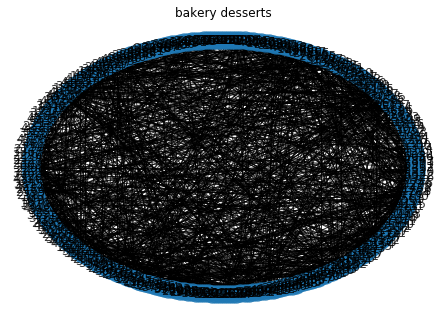

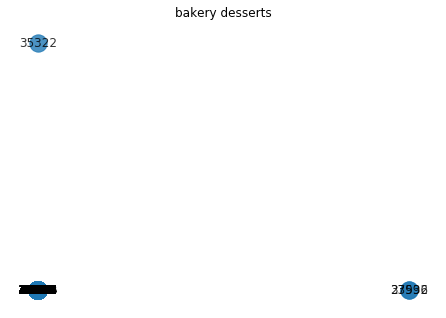

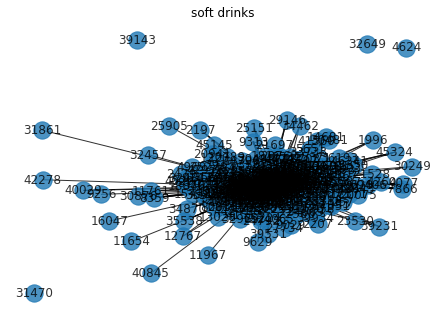

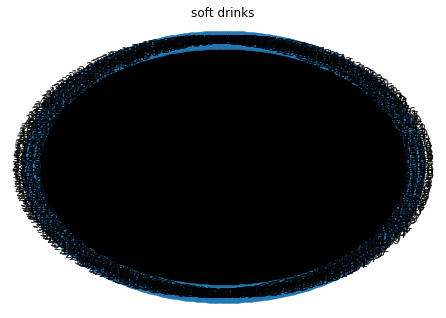

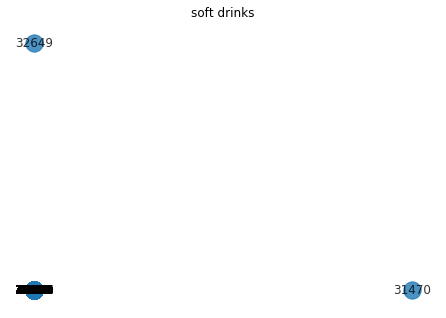

In [8]:
# just have a look
c=0
for aisle in food_aisles:
    c+=1
    if c>3:   # don't print all graphs, just a few
        break
    print('\n', aisle)
    G = nx.read_gpickle('prod_graphs_'+aisle+'.gpk')
    print(nx.info(G))
    plt.figure()
    nx.draw(G, with_labels=True,  alpha = 0.8)
    plt.title(aisle)
    plt.figure()
    nx.draw_circular(G, with_labels=True,  alpha = 0.8)
    plt.title(aisle)
    plt.figure()
    nx.draw_spectral(G, with_labels=True,  alpha = 0.8)
    plt.title(aisle)


We notice that these graphs are very dense. Therefore, it might be useful to remove small weight edges (if only very few users have bought a pair of products, they do not deserve to be linked).

Let's have a look at the edges weights:

In [13]:
def look_at_edges(G):
    edge_weights = [d['weight'] for (u, v, d) in G.edges(data=True)] # if d['weight'] < 200
    plt.figure()
    plt.hist(edge_weights, bins=100, log=True)
    print(np.quantile(edge_weights, [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 0.99]))

[4.70147932e-03 6.09756098e-03 7.42574257e-03 9.90099010e-03
 1.29310345e-02 1.78571429e-02 4.46538591e-02 2.20031748e-01
 1.37187493e+01]
[3.73414880e-03 4.54545455e-03 5.38021196e-03 7.44326694e-03
 1.07028266e-02 1.53846154e-02 3.37952098e-02 1.43682670e-01
 5.72278369e+00]
[6.45161290e-03 8.62068966e-03 1.08695652e-02 1.69491525e-02
 2.76073620e-02 4.65116279e-02 2.00000000e-01 2.95928366e+00
 1.59469724e+02]
[4.40335420e-03 6.75675676e-03 8.49763634e-03 1.36612022e-02
 2.00086779e-02 3.12500000e-02 1.05981892e-01 1.01440415e+00
 5.57480649e+01]
[4.86974067e-03 5.74386102e-03 7.29644251e-03 8.82667074e-03
 1.93188173e-02 3.61513686e-02 1.17477238e-01 9.75623717e-01
 2.65968083e+01]
[5.01739399e-03 6.77874652e-03 8.65800866e-03 1.36986301e-02
 2.12069851e-02 3.55842786e-02 1.37101657e-01 1.58185832e+00
 4.87795002e+01]
[5.65611342e-03 7.63358779e-03 1.03092784e-02 1.81443724e-02
 3.39418260e-02 6.62507427e-02 3.22207820e-01 4.64723518e+00
 2.73414895e+02]


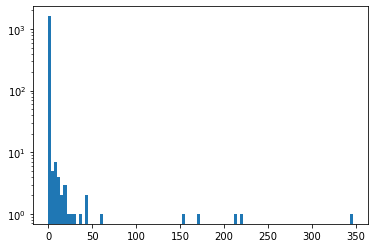

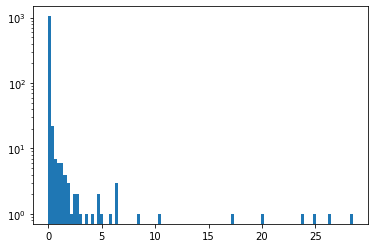

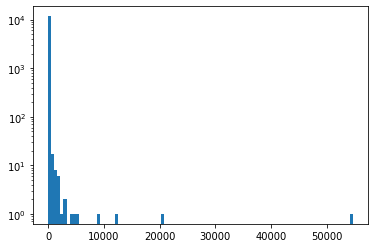

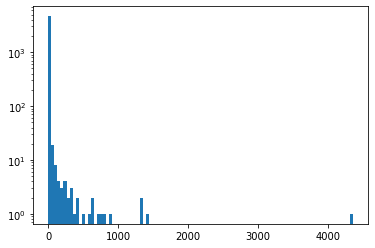

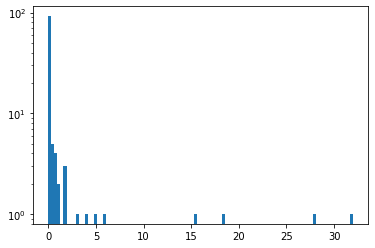

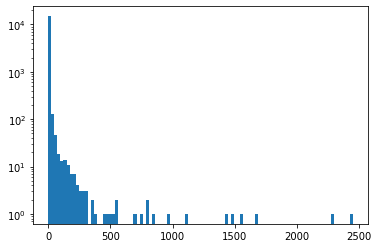

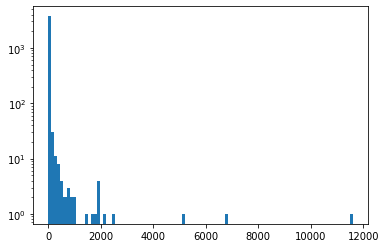

In [14]:
c=0
for aisle in food_aisles:
    c+=1
    if c>7:
        break
    look_at_edges(nx.read_gpickle('prod_graphs_'+aisle+'.gpk'))

The distribution of edges weights is extremely high on for very low weights. We choose to use the 30th percentile (_i.e._ remove the 30% lowest edges).

Define the function that, from a graph of products, removes the exceedingly numerous small edges (but reduces the percentile if too many products get disconnected from the graph). It also uses the inverse of the original weights as weights in order to enable looking for a shortest path.

In [21]:
def make_final_graph(G, aisle='None', threshold_quantile=0.3, verbose=False,save=False):
    print(aisle)
    edge_weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
    lost = len(G)
    threshold_quantile = 2 * threshold_quantile
    stop = False
    threshold = 0
    while lost > 0.15 * len(G) and not stop:            # while too many nodes get disconnected, ...
        threshold_quantile = threshold_quantile / 2     # ... reduce percentile of edges removed
        new_threshold = np.quantile(edge_weights, threshold_quantile)
        if threshold == new_threshold:   # if reducing the percentile ceases to change the threshold, stop
            stop=True
        else:
            threshold = new_threshold
        thresholded_inv_edges = []
        C=0
        for (u, v, d) in G.edges(data=True):
            C+=1
            if d['weight'] > threshold: # select heavy enough eg-dges
                nd = d.copy()
                nd['weight'] = 1. / d['weight'] # use inverse of weight
                thresholded_inv_edges.append((u,v,nd))
        # make graph from selected edges:
        thresholded_inv = nx.Graph(thresholded_inv_edges)
        lost = len(G)-len(thresholded_inv)   # number of nodes that got disconnected
    print('Lost products: {} of {}'.format(len(G)-len(thresholded_inv), len(G)))
    print("Used quantile: {}".format(threshold_quantile))
    if verbose:
        print('Avg shortest Path:', shortest_paths.generic.average_shortest_path_length(thresholded_inv))
        print('Avg weighted shortest Path:', shortest_paths.generic.average_shortest_path_length(thresholded_inv, weight='weight'))
        print(nx.info(G))
        print(nx.info(thresholded_inv))
    if save:
        nx.write_gpickle(thresholded_inv, 'thresholded_inv_'+aisle+'.gpk')
    return thresholded_inv


Make the graphs to be used for product recommendation.

In [22]:
for aisle in food_aisles:
    make_final_graph(nx.read_gpickle('prod_graphs_'+aisle+'.gpk'), aisle, save=True)
    print('Done', aisle)
    print()

fresh dips tapenades
Lost products: 19 of 327
Used quantile: 0.3
Done fresh dips tapenades

soup broth bouillon
Lost products: 29 of 737
Used quantile: 0.3
Done soup broth bouillon

frozen juice
Lost products: 8 of 47
Used quantile: 0.01875
Done frozen juice

ice cream toppings
Lost products: 13 of 85
Used quantile: 0.0046875
Done ice cream toppings

water seltzer sparkling water
Lost products: 13 of 344
Used quantile: 0.3
Done water seltzer sparkling water

spirits
Lost products: 17 of 195
Used quantile: 0.3
Done spirits

red wines
Lost products: 19 of 232
Used quantile: 0.3
Done red wines

baking ingredients
Lost products: 28 of 623
Used quantile: 0.3
Done baking ingredients

packaged cheese
Lost products: 14 of 891
Used quantile: 0.3
Done packaged cheese

beers coolers
Lost products: 32 of 385
Used quantile: 0.3
Done beers coolers

juice nectars
Lost products: 42 of 792
Used quantile: 0.3
Done juice nectars

frozen meals
Lost products: 16 of 880
Used quantile: 0.3
Done frozen meals


Make the function that, given a product (supposed not too healthy), outputs a recommended product (from the same aisle). The recommended product is selected among the 10 closest neighbours of the original product, based on a score taking into account distance to original, healthiness, and fidelity (~satisfaction) of consumers.

In [22]:
def find_recommendation_path(source_id, G=None, aisle=None, health_thresh=2, product_scores=None, alpha=.3, beta=.2):
    """alpha is coefficient for healthiness, beta coefficient for fidelity, and 1-alpha-beta is coefficient for distance."""
    if G is None:
        G = nx.read_gpickle('thresholded_inv_'+aisle+'.gpk')
    if product_scores is None:
        product_scores = pd.read_pickle('GOOD_product_scores.pk')
    
    # select target products defined as having a healthiness greater than health_thresh
    targets = set()
    for x in G.nodes:
        if x in product_scores.index and product_scores.at[x, "healthiness"] >= health_thresh:
            targets.add(x)
    print('Nb of targets:', len(targets))
    
    # do not allow paths through products that are even less healthy than source:
    G_ok = G.subgraph({x for x in G.nodes if x in product_scores.index and product_scores.at[x, "healthiness"] >= product_scores.at[source_id, "healthiness"]})
    
    # find all shortest paths from source:
    pred, lengths = nx.dijkstra_predecessor_and_distance(G_ok, source_id, weight='weight')
    
    # find 10 closest target neighbours:
    candidates = [(-np.inf, None)]
    sep = []
    for candidate in targets:
        if candidate not in lengths:   # ie it is not connected to source
            sep.append(candidate)
        if candidate in lengths and - lengths[candidate] > candidates[0][0]:   # ie candidate is closer than all current candidates
            if len(candidates) >= 10:
                hp.heappop(candidates)
            hp.heappush(candidates, (- lengths[candidate], candidate))
    if len(sep) == len(targets):
        print("not connected to any healthy product")
        return
    if candidates == [(-np.inf, None)]:
        print('No path to healthy products')
        return
    
    # find the distances, healthinesses and fidelities of all ten candidates for min-max scaling
    fids = []
    dists = []
    healths = []
    for (mdist, candidate) in candidates:
        if mdist == -np.inf:
            continue
        fids.append(product_scores.at[candidate, 'fidelity'])
        dists.append(- mdist)
        healths.append(product_scores.at[candidate, 'healthiness'])
    max_fid = max(fids)
    min_fid = min(fids)
    max_dist = max(dists)
    min_dist = min(dists)
    max_health = max(healths)
    min_health = min(healths)
    
    rec = (0, None)
    for (mdist, candidate) in candidates:
        if mdist == -np.inf:
            continue
        # perform min-max scaling
        fid = ((product_scores.at[candidate, 'fidelity'] - min_fid) / (max_fid - min_fid)) if max_fid != min_fid else 0
        dist = ((max_dist + mdist) / (max_dist - min_dist)) if max_dist != min_dist else 0
        health = ((product_scores.at[candidate, "healthiness"] - min_health) / (max_health - min_health)) if max_health != min_health else 0
        # compute aggregate score
        score = (1+health)**alpha * (1+fid)**beta * (1+dist)**(1-alpha-beta)
        if score > rec[0]:   # choose best scoring product
            rec = (score, candidate)
    
    # now build path between recommended product and source
    orig = rec[1]
    path = [orig]
    while orig != source_id:
        orig = pred[orig][0]
        path.append(orig)
    
    path.reverse()
    return path

In [23]:
find_recommendation_path(3265, aisle='packaged produce')

Nb of targets: 4


[3265, 12341, 21385]

### Recommend products

Let's find some real recommendations for some products that users from the cluster 0 (considered the least healthy) have made:

Get orders from "unhealthy" users:

In [194]:
orders_products = pd.read_pickle('orders_products.pk')
with open('THE_GOOD_users_cluster.pk', 'rb') as f:
    users_cluster = pk.load(f)
unhealthy = set(u+1 for u in range(len(users_cluster)) if users_cluster[u]==0)
unhealthy_orders = orders_products[orders_products.user_id.isin(unhealthy)]
unhealthy_food_orders = unhealthy_orders[unhealthy_orders.apply(lambda row: prod_lit.at[row.product_id, 'aisle'] in food_aisles, axis=1)]

Sample some orders:

In [199]:
some_unhealthy_orders = unhealthy_orders.sample(100)[['order_id', 'user_id', 'product_id']]

In [200]:
some_unhealthy_orders.head()

,order_id,user_id,product_id
2395924,1415083,34573,26620
5887249,222033,84623,19333
11384403,850612,164075,35413
11647548,387635,168070,15700
6889329,1325971,98979,17706


In [188]:
prod_lit = products_litteral.set_index('product_id')
prod_lit.head()

,product_name,aisle,department
product_id,,,
1,Chocolate Sandwich Cookies,cookies cakes,snacks
78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
102,Danish Butter Cookies,cookies cakes,snacks
172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


Find recommendations for selected orders:

In [201]:
for _, row in some_unhealthy_orders.iterrows():
    try:
        print('For user ', row.user_id)
        print('Path from', prod_lit.at[row.product_id, 'product_name'], 'with healthiness', product_scores.at[row.product_id, 'healthiness'])
        path = find_recommendation_path(row.product_id, aisle=prod_lit.at[row.product_id, 'aisle'], product_scores=product_scores)
        target = path[-1]
        print('To', prod_lit.at[target, 'product_name'], 'with healthiness', product_scores.at[target, 'healthiness'])
        print()
    except:
        print('============================= Echec: For user ', row.user_id)
        print('Path from', prod_lit.at[row.product_id, 'product_name'], 'with healthiness', product_scores.at[row.product_id, 'healthiness'])
        print()
        

For user  34573
Path from Peach Pear Flavored Sparkling Water with healthiness 1.8428691983122363
Nb of targets: 80
To Italian Sparkling Mineral Water with healthiness 2.645234133586879

For user  84623
Path from Select 100% Whole Wheat Sandwich Rolls with healthiness 1.5688622754491017
Nb of targets: 65
To Hamburger Buns Whole Grain with healthiness 2.212121212121212

For user  164075
Path from Freshly made pasta layered between a rich meat sauce and topped with Real Mozzarella cheese Lasagna with Meat & Sauce with healthiness -0.03879310344827586
Nb of targets: 49
To Organic Brown Rice with healthiness 2.5913242009132422

For user  168070
Path from Cheddar Cheese Nut Thins Cracker Snacks with healthiness 1.9688412852969814
Nb of targets: 272
To Hint Of Sea Salt Almond Nut Thins with healthiness 2.2302728072748605

For user  98979
Path from Organic Whole Grain Wheat English Muffins with healthiness 2.3905109489051095
Nb of targets: 65
To Organic Sprouted Wheat Bagels with healthiness 

To Sea Salt Pita Chips with healthiness 2.2629550321199146

For user  310
Path from Strawberry Watermelon Liquid Water Enhancer with healthiness 0.2777777777777778
Nb of targets: 42
To Fit Artic Grape Energy Drink Drops with healthiness 2.4324324324324325

For user  19432
Path from Toasted Coconut Almondmilk Blend with healthiness 2.339177924691003
Nb of targets: 175
To Toasted Coconut Almondmilk Blend with healthiness 2.339177924691003

For user  33216
Path from Strawberries with healthiness 1.9130029007441038
Nb of targets: 230
To Organic Avocado with healthiness 2.676720345399112

For user  118878
Path from Zero Calorie Cola with healthiness -0.49011358855700465
Nb of targets: 52
To Premium Indian Tonic Water with healthiness 2.356394129979036

For user  199535
Path from Roasted Vegetable Ravioli with healthiness 2.0434782608695654
Nb of targets: 66
To Asparagus & Gruyere Ravioli with healthiness 2.953488372093023

For user  148367
Path from Organic Shredded Carrots with healthiness

To Organic Hass Avocado with healthiness 2.670946515943985

For user  128456
Path from Regular with healthiness 0.24437299035369775
Nb of targets: 52
To Premium Indian Tonic Water with healthiness 2.356394129979036

For user  72436
Path from Classic Mix Variety with healthiness 0.2275320970042796
Nb of targets: 318
To Sea Salt Pita Chips with healthiness 2.2629550321199146

For user  88800
Path from Lemon Fruit & Nut Food Bar with healthiness 2.1363636363636362
Nb of targets: 257
To Banana Bread Fruit & Nut Bar with healthiness 2.425531914893617



### See whether the healthiness measure makes sense

Compute average healthiness per aisle:

In [153]:
healthiness_per_aisle = {}
for aisle in food_aisles:
    healthiness_per_aisle[aisle] = pd.merge(by_aisle[aisle], product_scores, left_on='product_id', right_on='product_id')

In [139]:
for aisle in food_aisles:
    print(aisle, healthiness_per_aisle[aisle].mean()['healthiness'])
    print("====================")

fresh dips tapenades 1.79067887398118
soup broth bouillon 1.3941966800804526
frozen juice 1.0399514338822409
ice cream toppings 1.0968692866158418
water seltzer sparkling water 1.239112564552592
spirits 0.9567987921439435
red wines 1.2536254665546902
baking ingredients 2.0264213261744666
packaged cheese 1.6896491572413097
beers coolers 0.7434820461027672
juice nectars 1.3837646252983895
frozen meals 0.26754207134166325
breakfast bakery 1.3105598454455978
tea 1.6290213434255987
tortillas flat bread 2.0540074158785098
other creams cheeses 1.5916253128196411
energy granola bars 1.4709370754426256
chips pretzels 1.326160376033867
preserved dips spreads 1.7477633195423563
hot cereal pancake mixes 1.801588915528622
bulk dried fruits vegetables 2.2577091884944296
milk 1.668663495031789
frozen dessert 0.9712701079368742
dry pasta 2.3914223590514916
eggs 2.1004976545045837
specialty wines champagnes 1.1275023532279624
packaged vegetables fruits 1.8773111512029206
hot dogs bacon sausage 1.679239

See what proportion of products of each aisle are considered "target" products:

In [24]:
for aisle in food_aisles:
    t = 0
    g = 0
    lst = []
    for ind in by_aisle[aisle]['product_id']:
        if ind in product_scores.index:
            lst.append(product_scores.at[ind, 'healthiness'])
        if ind in product_scores.index and product_scores.at[ind, 'healthiness']>=2:
            g += 1
        t+=1
    print(aisle, float(g)/t, g, t)

NameError: name 'by_aisle' is not defined

This is necessary to use dataframe from Pierre's notebook:

In [ ]:
product_scores = pd.read_pickle('GOOD_product_scores')

In [132]:
product_scores.columns=['healthiness', 'count', 'fidelity']

In [133]:
product_scores.set_index(product_scores.index.astype(int)).to_pickle('GOOD_product_scores.pk')

In [ ]:
product_scores = pd.read_pickle('GOOD_product_scores.pk')